In [1]:
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple

sys.path.append("models/segment-anything")
from utils.dataset import ParcelDataset
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

# Load the dataset
dataset = ParcelDataset(path="data/france/images/")

sam = sam_model_registry["default"](checkpoint="models/segment-anything/chkpts/sam_vit_h.pth")
_ = sam.to(device="cuda")
output_mode = "binary_mask"
generator = SamAutomaticMaskGenerator(sam, output_mode=output_mode)

In [15]:
idx = np.random.randint(0,len(dataset))
image, label = dataset[idx]
image, label = image[0], label
img_shape = image.shape

# Create the Overlay image
label_overlay = np.zeros(img_shape)
for l in label:
    # Generate a random color
    color = np.random.randint(0, 255, 3)
    # Assign the color to the mask and update overlay
    color_idx = np.where(l != False)
    label_overlay[color_idx[0], color_idx[1], :] = color
    
label_overlay = label_overlay.astype(np.uint8)

In [39]:
def parse_masks(masks: List[Dict[str, Any]]) -> Tuple[Dict, np.array]:
    """Parse the masks into a dictionary.
    Args:
        masks: The masks to parse.
    Returns:
        A dictionary containing the parsed masks.
    """
    export_masks_meta = []
    export_masks = []
    for i, mask_data in enumerate(masks):
        if mask_data["area"] < 50:
            continue
        if mask_data["area"] > 40000:
            continue
        mask = mask_data["segmentation"]
        mask_metadata = {
            "id": str(i),
            "area": str(mask_data["area"]),
            "bbox_x0": str(mask_data["bbox"][0]),
            "bbox_y0": str(mask_data["bbox"][1]),
            "bbox_w": str(mask_data["bbox"][2]),
            "bbox_h": str(mask_data["bbox"][3]),
            "point_input_x": str(mask_data["point_coords"][0][0]),
            "point_input_y": str(mask_data["point_coords"][0][1]),
            "predicted_iou": str(mask_data["predicted_iou"]),
            "stability_score": str(mask_data["stability_score"]),
            "crop_box_x0": str(mask_data["crop_box"][0]),
            "crop_box_y0": str(mask_data["crop_box"][1]),
            "crop_box_w": str(mask_data["crop_box"][2]),
            "crop_box_h": str(mask_data["crop_box"][3]),
            # "image": mask,
        }
        export_masks_meta.append(mask_metadata)
        export_masks.append(mask)

    return export_masks_meta, np.array(export_masks)

In [ ]:
masks = generator.generate(image)
print("Masks Detected =", len(masks))

In [18]:
mask_meta, parsed_masks = parse_masks(masks)

# Create the Overlay image
mask_overlay = np.zeros(img_shape)
for mask in parsed_masks:
    # Generate a random color
    color = np.random.randint(0, 255, 3)
    # Assign the color to the mask and update overlay
    color_idx = np.where(mask != False)
    mask_overlay[color_idx[0], color_idx[1], :] = color
    
mask_overlay = mask_overlay.astype(np.uint8)

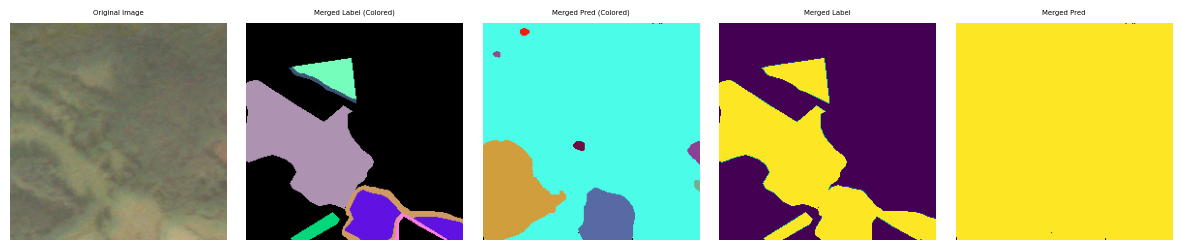

In [19]:
def display_images_horizontally(images, titles):
    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(images), figsize=[15,15])

    # Iterate over the images and display them
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(titles[i],fontsize=5)


    # Adjust spacing and display the figure
    plt.subplots_adjust(wspace=0.09)
    plt.show()

# Merge the labels
merged_label = np.zeros(img_shape[:2])
label_idx = np.where(label_overlay != [0,0,0])
merged_label[label_idx[0], label_idx[1]] = 255

# Merge the predictions
merged_pred = np.zeros(img_shape[:2])
pred_idx = np.where(mask_overlay != [0,0,0])
merged_pred[pred_idx[0], pred_idx[1]] = 255

images = [image, label_overlay, mask_overlay, merged_label, merged_pred]
titles = ['Original Image', 'Merged Label (Colored)', 'Merged Pred (Colored)', 'Merged Label', 'Merged Pred']
display_images_horizontally(images,titles)

In [20]:
from utils.evaluator import evaluate_instance_segmentation
from scipy.optimize import linear_sum_assignment

def calculate_iou(pred_mask, gt_mask):
    """Calculate IoU for a single predicted and ground truth mask.
    Args:
        pred_mask (numpy array): Predicted mask of shape (H, W)
        gt_mask (numpy array): Ground truth mask of shape (H, W)
    Returns:
        iou (float): Value of IoU for the two masks
    """
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def evaluate_instance_segmentation(pred_masks, gt_masks):
    """Evaluate instance segmentation using mean IoU.
    Args:
        pred_masks (numpy array): Array of predicted masks of shape (N, H, W)
        gt_masks (numpy array): Array of ground truth masks of shape (N, H, W)
    Returns:
        mean_iou (float): Mean IoU
    """
    num_pred_instances = len(pred_masks)
    num_gt_instances = len(gt_masks)
    iou_matrix = np.zeros((num_pred_instances, num_gt_instances))
    
    # Calculate IoU for all pairs of predicted and ground truth masks
    for i in range(num_pred_instances):
        for j in range(num_gt_instances):
            pred_mask = pred_masks[i]
            gt_mask = gt_masks[j]
            iou_matrix[i, j] = calculate_iou(pred_mask, gt_mask)
    
    # Perform optimal matching using Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    # Calculate mean IoU using the matched pairs
    matched_ious = iou_matrix[row_ind, col_ind]
    
    # Calculate Precision and Recall
    p_50, r_50 = calculate_precision_recall(matched_ious, num_pred_instances, num_gt_instances, threshold=0.5)
    p_70, r_70 = calculate_precision_recall(matched_ious, num_pred_instances, num_gt_instances, threshold=0.7)
    p_90, r_90 = calculate_precision_recall(matched_ious, num_pred_instances, num_gt_instances, threshold=0.9)
    
    mean_iou = np.mean(matched_ious)
    
    return mean_iou, p_50, r_50, p_70, r_70, p_90, r_90

def calculate_precision_recall(matched_ious, num_pred_instances, num_gt_instances, threshold=0.5):
    num_true_positives = len(matched_ious[matched_ious >= threshold])
    num_false_positives = num_pred_instances - num_true_positives
    num_false_negatives = num_gt_instances - num_true_positives
    precision = num_true_positives / (num_true_positives + num_false_positives)
    recall = num_true_positives / (num_true_positives + num_false_negatives)
    
    return precision, recall

In [21]:
mean_iou, p_50, r_50, p_70, r_70, p_90, r_90 = evaluate_instance_segmentation(parsed_masks, label)
mean_iou, p_50, r_50, p_70, r_70, p_90, r_90

(0.12042002534932998, 0.125, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0)

## Evaluate the whole dataset

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['parcel_id', 'gt_label_ct', 
                           'predicted_label_ct', 'mean_iou', 
                           'p_50', 'r_50', 'p_70', 'r_70', 'p_90', 'r_90'
                          ])
for idx in range(len(dataset)):
    image, label = dataset[idx]
    preds = generator.generate(image[0])
    mask_meta, parsed_masks = parse_masks(masks)
    mean_iou, p_50, r_50, p_70, r_70, p_90, r_90 = evaluate_instance_segmentation(parsed_masks, label)
    df.loc[idx] = [idx, len(label), len(parsed_masks), mean_iou, p_50, r_50, p_70, r_70, p_90, r_90]

In [46]:
df.to_json('evaluations.json', orient = 'split', compression = 'infer', index = 'true')

In [52]:
max(df['mean_iou'])

0.47432156405018966